# Neural Networks

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy import io
from scipy.special import expit
%matplotlib inline

### Feedforward

This carries over from the last exercise. We will use a pretrained network here.

In [5]:
# Training data
data = io.loadmat(os.path.join('data', 'ex4data1.mat'))
X, y = data['X'], data['y'].flatten()
y[y == 10] = 0 # from matlab indexing to python indexing
m, n = X.shape

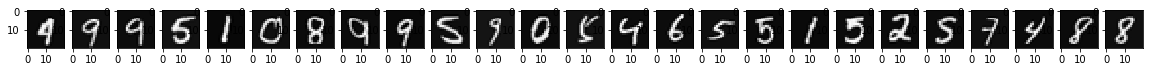

In [8]:
# Visualize data
nrows = 25

def row_to_square(X_row):
    return np.reshape(X_row, (20, 20)).T

# Choose nrows random rows of X.
indices = np.random.randint(m, size=nrows)
X_sel = X[indices, :]

fig, ax = plt.subplots(1, nrows, figsize=(20, 20))

for i in range(nrows):
    ax[i].imshow(row_to_square(X_sel[i, :]), cmap='gray')

#### Network Model

The images are of size $20 \times 20$, so there are 400 (n) input layer units. The hidden layer has 25 units, and since there are 10 digits, therefore the output layer has 10 units. 

In [33]:
input_layer_size = n
hidden_layer_size = 25
num_labels = 10

weights = io.loadmat(os.path.join('data', 'ex4weights.mat'))
theta1, theta2 = weights['Theta1'], weights['Theta2']
theta2 = np.roll(theta2, 1, axis=0) # Matlab legacy
nn_params = np.concatenate([theta1.ravel(), theta2.ravel()])

#### Cost function

In [155]:
def feed_forward(thetas, x):
    """
    Propagate a the input data through the network. 
    The thetas is a array of weights for each layer of the network. 
    """
    a = np.copy(x.T)
    az_arr = []
    for theta in thetas:
        a = np.insert(a, 0, 1, axis=0)
        z = np.einsum('ik,kj->ij', theta, a)
        a = expit(z)
        az_arr.append((z, a))
    return az_arr
        
def map_y(y):
    """
    To train the network we need to encode the labels as vectors containing
    0s or 1s. i.e. each entry in the original y matrix will correspond to a 
    vector, containing 0s or 1s, of length num_labels.
    For example, in this case if the i-th entry of y is 5, then the 
    corresponding vector will be the transpose of [0, 0, 0, 0, 1, 0, 0, 0, 0].
    """
    m = y.size
    mapped_y = np.zeros((num_labels, m))
    for i in range(m):
        mapped_y[y[i], i] = 1
    return mapped_y

def unroll_params(nn_params):
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], 
                        (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                       (num_labels, (hidden_layer_size + 1)))
    return theta1, theta2
    
def cost_function(nn_params, x, y, regulator=0):
    m, n = x.shape
    thetas = np.array(unroll_params(nn_params))
    mapped_y = map_y(y)
    hypothesis = feed_forward(thetas, x)[1][1]
    term1 = -np.einsum('ij,ij->', mapped_y, np.log(hypothesis))
    term2 = np.einsum('ij,ij->', (1 - mapped_y), np.log(1 - hypothesis))
    cost = (term1 - term2) / m
    cost = np.sum(cost)
    reg_arr = np.asarray([np.sum(theta * theta) for theta in thetas])
    reg_term = (regulator / 2 / m) * np.sum(reg_arr)
    return cost + reg_term

In [156]:
cost_function(nn_params, X, y)

0.2876291651613189

In [147]:
cost_function(nn_params, X, y, 1)

0.384487796242894

### Back Propagation

Here we will train the network using the back propagation algorithm.

In [73]:
def sigmoid_gradient(z):
    return expit(z) * (1 - expit(z))

In [81]:
z = np.linspace(-1, 1, 5)
sigmoid_gradient(z)

array([0.19661193, 0.23500371, 0.25      , 0.23500371, 0.19661193])

In [82]:
def gen_random_weights(lin, lout):
    eps = np.sqrt(6) / np.sqrt(lin + lout)
    w = np.random.rand(lout, lin + 1) * 2 * eps - eps
    return w

In [88]:
initial_theta1 = gen_random_weights(input_layer_size, hidden_layer_size)
initial_theta2 = gen_random_weights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([initial_theta1.ravel(), initial_theta2.ravel()], axis=0)

In [228]:
def back_propagation(nn_params, x, y, regulator=0):
    m, n = x.shape
    
    # Gradient arrays
    theta1, theta2 = unroll_params(nn_params)
    D1 = np.zeros_like(theta1)
    D2 = np.zeros_like(theta2)
    
    # Feed forward
    az_arr = feed_forward([theta1, theta2], x)
    a3 = az_arr[1][1] # 10 x 5000
    z3 = az_arr[1][0] # 10 x 5000
    a2 = az_arr[0][1] # 25 x 5000
    z2 = az_arr[0][0] # 25 x 5000
    a1 = np.insert(x, 0, 1, axis=1) # 5000 x 401
    
    # Error at each node
    mapped_y = map_y(y)
    delta3 = a3 - mapped_y
    delta2 = np.dot(theta2.T, delta3)[1:] * sigmoid_gradient(z2)
    
    # Unregularized gradient
    D1 = (D1 + np.dot(delta2, a1)) / m # 25 x 401
    D2[:, 1:] = (D2[:, 1:] + np.dot(delta3, a2.T)) / m # 10 x 25
    
    # Regularization
    D1[:, 1:] = D1[:, 1:] + (regulator / m) * theta1[:, 1:]
    D2[:, 1:] = D2[:, 1:] + (regulator / m) * theta2[:, 1:]
    
    return np.concatenate([D1.ravel(), D2.ravel()])

In [256]:
# Training

def train_network(initial_nn_params, x, y, regulator=0, iters=100):
    result = opt.minimize(cost_function, initial_nn_params,
                          args=(x, y, regulator),
                          jac=back_propagation, method='TNC',
                          options={'maxiter': iters})
    return result.x

In [254]:
# Train and predict

nn_params = train_network(initial_nn_params, X, y)
theta1, theta2 = unroll_params(nn_params)
prediction = np.argmax(feed_forward([theta1, theta2], X)[1][1], axis=0)
np.mean(prediction == y) * 100

95.46

This network predicts the training data with an average accuracy of 95.46%. This could possibly be overfitting. One way to go around this would be to have a nonzero regulator.

In [257]:
nn_params = train_network(initial_nn_params, X, y, 1)
theta1, theta2 = unroll_params(nn_params)
prediction = np.argmax(feed_forward([theta1, theta2], X)[1][1], axis=0)
np.mean(prediction == y) * 100

93.97999999999999

In [258]:
nn_params = train_network(initial_nn_params, X, y, 0.1, 150)
theta1, theta2 = unroll_params(nn_params)
prediction = np.argmax(feed_forward([theta1, theta2], X)[1][1], axis=0)
np.mean(prediction == y) * 100

99.02

In [259]:
nn_params = train_network(initial_nn_params, X, y, 10, 150)
theta1, theta2 = unroll_params(nn_params)
prediction = np.argmax(feed_forward([theta1, theta2], X)[1][1], axis=0)
np.mean(prediction == y) * 100

93.76